In [1]:
import datetime
import pandas as pd
import numpy as np
import pandas_datareader as pdr

In [2]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

In [3]:
btc_data = pdr.get_data_yahoo(['BTC-USD'], start=datetime.datetime(2019, 1, 1), end=datetime.datetime(2022, 6, 30))
btc_data

Attributes,Adj Close,Close,High,Low,Open,Volume
Symbols,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,,
2018-12-31,3742.700439,3742.700439,3868.742920,3725.867432,3866.839111,4661840806
2019-01-01,3843.520020,3843.520020,3850.913818,3707.231201,3746.713379,4324200990
2019-01-02,3943.409424,3943.409424,3947.981201,3817.409424,3849.216309,5244856836
2019-01-03,3836.741211,3836.741211,3935.685059,3826.222900,3931.048584,4530215219
2019-01-04,3857.717529,3857.717529,3865.934570,3783.853760,3832.040039,4847965467
...,...,...,...,...,...,...
2022-06-26,21027.294922,21027.294922,21783.724609,21016.269531,21496.494141,18027170497
2022-06-27,20735.478516,20735.478516,21478.089844,20620.199219,21028.238281,20965695707


In [4]:
btc_data.columns[2][0]

'High'

In [5]:
adj_cols = [btc_data.columns[x][0] for x in range(len(btc_data.columns))]
adj_cols

['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']

In [6]:
btc_data.columns =  adj_cols
btc_data.tail()

,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2022-06-26,21027.294922,21027.294922,21783.724609,21016.269531,21496.494141,18027170497
2022-06-27,20735.478516,20735.478516,21478.089844,20620.199219,21028.238281,20965695707
2022-06-28,20280.634766,20280.634766,21164.423828,20228.812500,20731.544922,21381535161
2022-06-29,20104.023438,20104.023438,20364.156250,19937.791016,20281.169922,23552740328
2022-06-30,19784.726562,19784.726562,20141.160156,18729.656250,20108.312500,26267239923


In [7]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

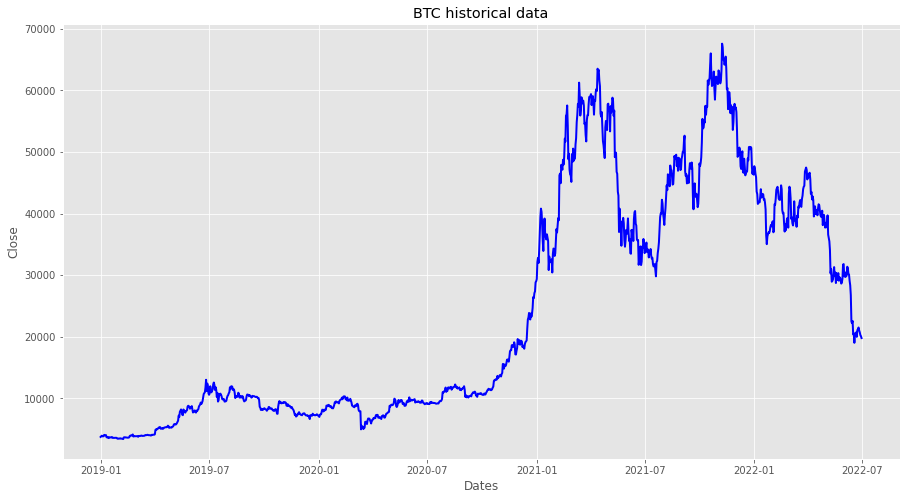

In [8]:
# plotting the column close
plt.figure(figsize=(15, 8))
plt.plot(btc_data['Close'], c='blue', linewidth=2)
plt.title("BTC historical data")
plt.xlabel("Dates")
plt.ylabel("Close")
plt.show()

#### The graph dosen't seem to show any stationarity and there's hardly any seasonal component present

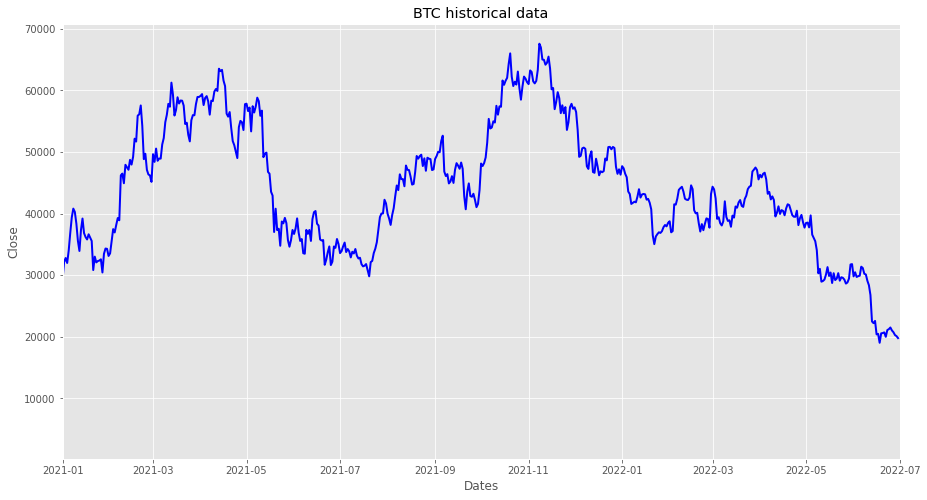

In [9]:
plt.figure(figsize=(15, 8))
plt.plot(btc_data['Close'], c='blue', linewidth=2)
plt.xlim((datetime.datetime(2021, 1, 1), datetime.datetime(2022, 7, 1)))
plt.title("BTC historical data")
plt.xlabel("Dates")
plt.ylabel("Close")
plt.show()

#### checking with monthly window moving average to find out any trend

In [10]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'r', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], 'b', label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)

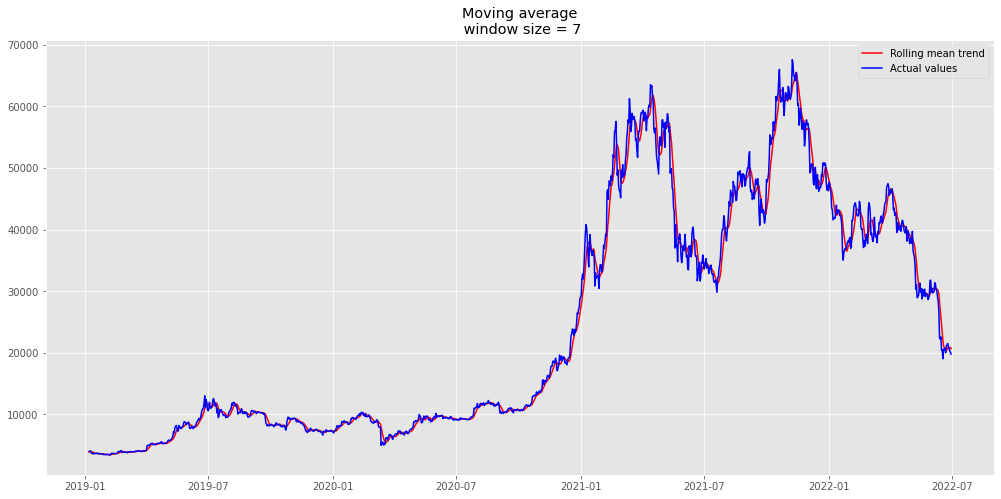

In [11]:
# check the MA for 7 days window
plot_moving_average(btc_data['Close'], 7)

#### For weekly window there is hardly any trend as its quite closer to the actual values. Lets check with 30 days and 90 days rolling window

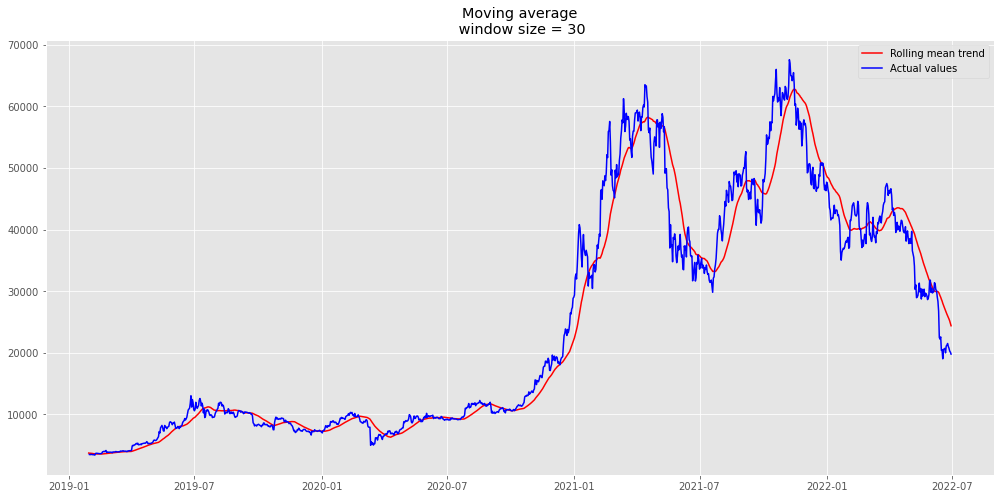

In [12]:
plot_moving_average(btc_data['Close'], 30)

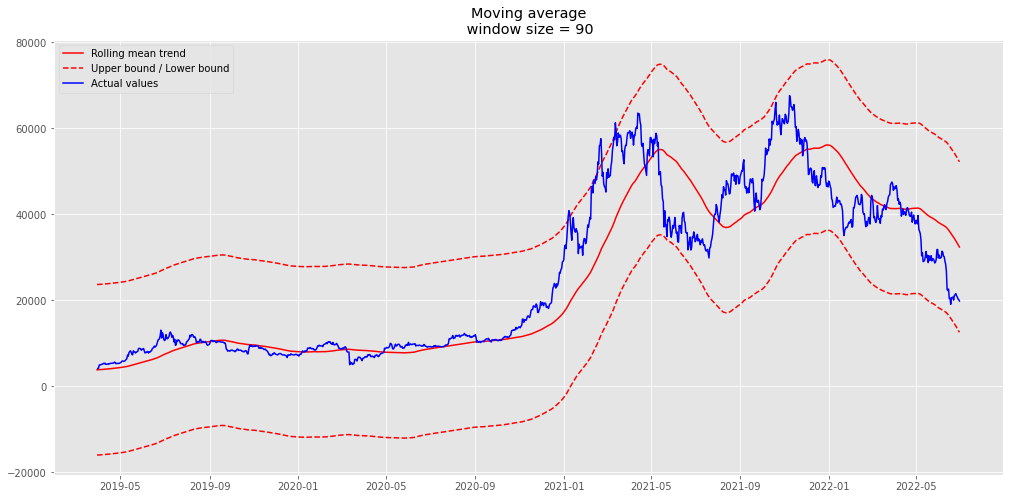

In [13]:
plot_moving_average(btc_data['Close'], 90, plot_intervals=True)

### The trends for 30 days and 90 days are more easier to spot. There is a downward curve at the end, which could mean there is going to be a drop likely in the bitcoin price in following days.

#### Lets check with exponentially weighted moving average to see if we can find a better trend

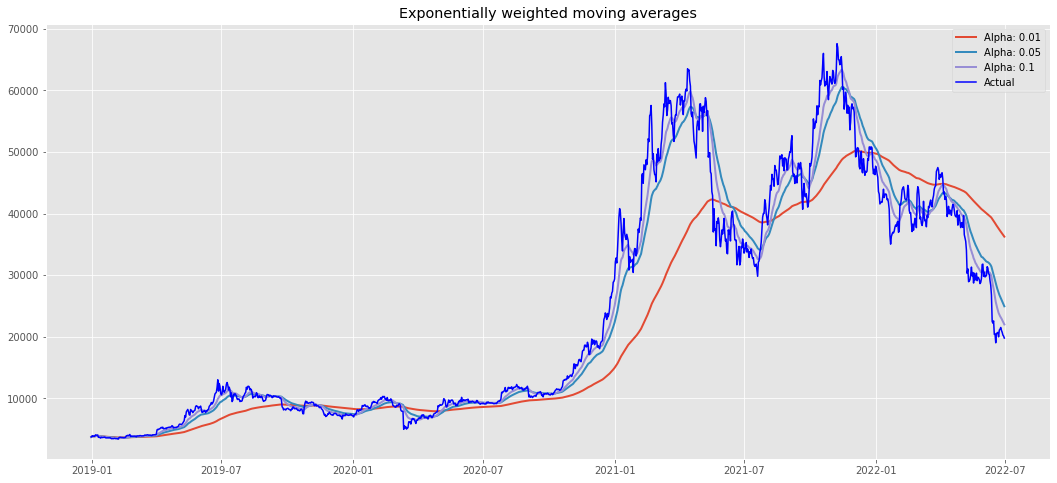

In [14]:
fig = plt.figure(figsize=(18, 8))
for alpha in [0.01, 0.05, 0.1]:
    plt.plot(btc_data['Close'].ewm(alpha=alpha).mean(), label="Alpha: {}".format(alpha), linewidth=2)
plt.plot(btc_data['Close'], label="Actual", c='b')
plt.title("Exponentially weighted moving averages")
plt.legend(loc='best', fontsize=10)
plt.axis('tight')
plt.show()

<Figure size 1296x720 with 0 Axes>

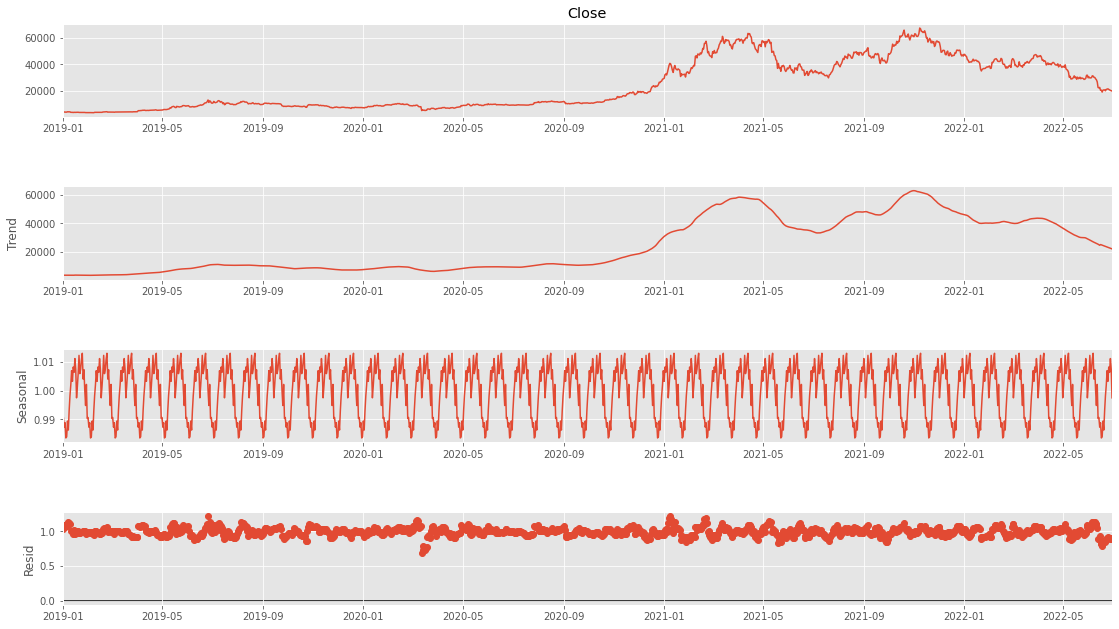

In [15]:
# Lets plot with seasonal decomposition and check trend, seasonality and noise
from statsmodels.tsa.seasonal import seasonal_decompose
decomposed = seasonal_decompose(btc_data['Close'], model='multiplicative', extrapolate_trend='freq', period=30)
fig = plt.figure(figsize=(18, 10))
fig = decomposed.plot()
fig.set_size_inches(18, 10)
plt.show()

### The trend of bitcoin prices is obviously unstable.

<AxesSubplot:xlabel='Date'>

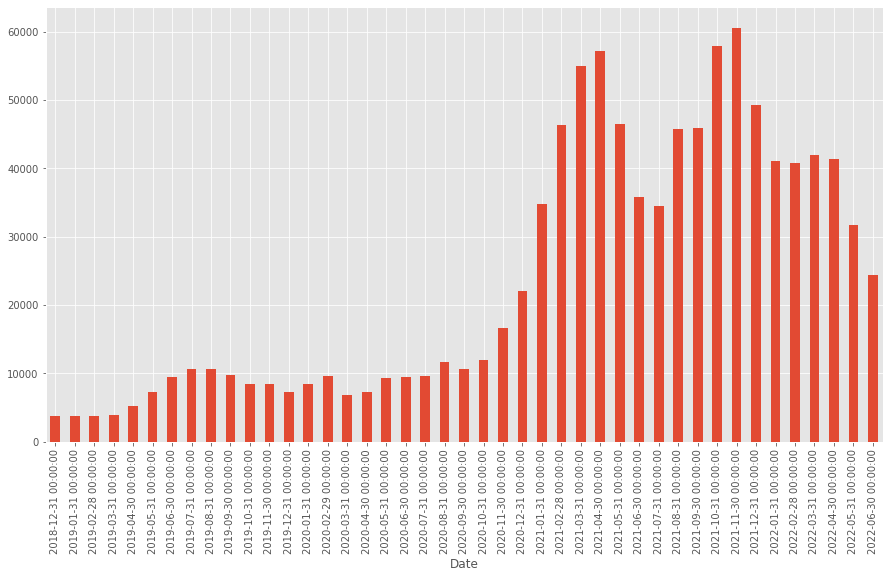

In [16]:
# Monthly closing prices mean of bitcoin prices
btc_data['Close'].resample(rule='M').mean().plot(kind='bar', figsize=(15, 8))

#### As previous plots suggested there is a downward trend in monthly averages.

### Modeling

#### Check with the ACF and PACF plot to find out MA(q) and AR(p) and also I(d) if needed. First lets test with Dickey Fuller test to verify stationarity, p-value and other test statistics

In [17]:
from statsmodels.tsa.stattools import adfuller

In [18]:
def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    print("No. of lags used: %s"%result[2])
    output = dict()
    for key,values in result[4].items():
        output['critical value (%s)'%key] =  values
    for key, value in output.items():
        print(key, " : ", value)

In [19]:
adf_test(btc_data['Close'])

ADF Statistics: -1.402620208488173
p- value: 0.5810193149736486
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 
No. of lags used: 12
critical value (1%)  :  -3.435529936129535
critical value (5%)  :  -2.863827487792138
critical value (10%)  :  -2.5679878818603634


In [20]:
# Lets check with first difference
btc_data['Close: 1st_diff'] = btc_data['Close'] - btc_data['Close'].shift(1)
adf_test(btc_data['Close: 1st_diff'].dropna())

ADF Statistics: -10.178952402782572
p- value: 6.774453123172651e-18
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary
No. of lags used: 11
critical value (1%)  :  -3.435529936129535
critical value (5%)  :  -2.863827487792138
critical value (10%)  :  -2.5679878818603634


### By doing first difference only we are getting stationary data with way less p-value and lesser test statistics than the critical values too. So out Integration(d) value can be 1.

In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [22]:
def plot_tsa(series, lags=None):
    
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    
    fig, ax = plt.subplot_mosaic([['ts', 'ts'], ['acf', 'pacf']], constrained_layout=True, figsize=(18, 10))
    ax['ts'].plot(series)
    p_val = adfuller(series)[1]
    ax['ts'].set_title("Time series analysis\nDickey Fuller test: p-value: {0:.5f}".format(p_val))
    plot_acf(series, lags=lags, ax=ax['acf'])
    plot_pacf(series, lags=lags, ax=ax['pacf'])

E:\ProgramData\Miniconda3\envs\py3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


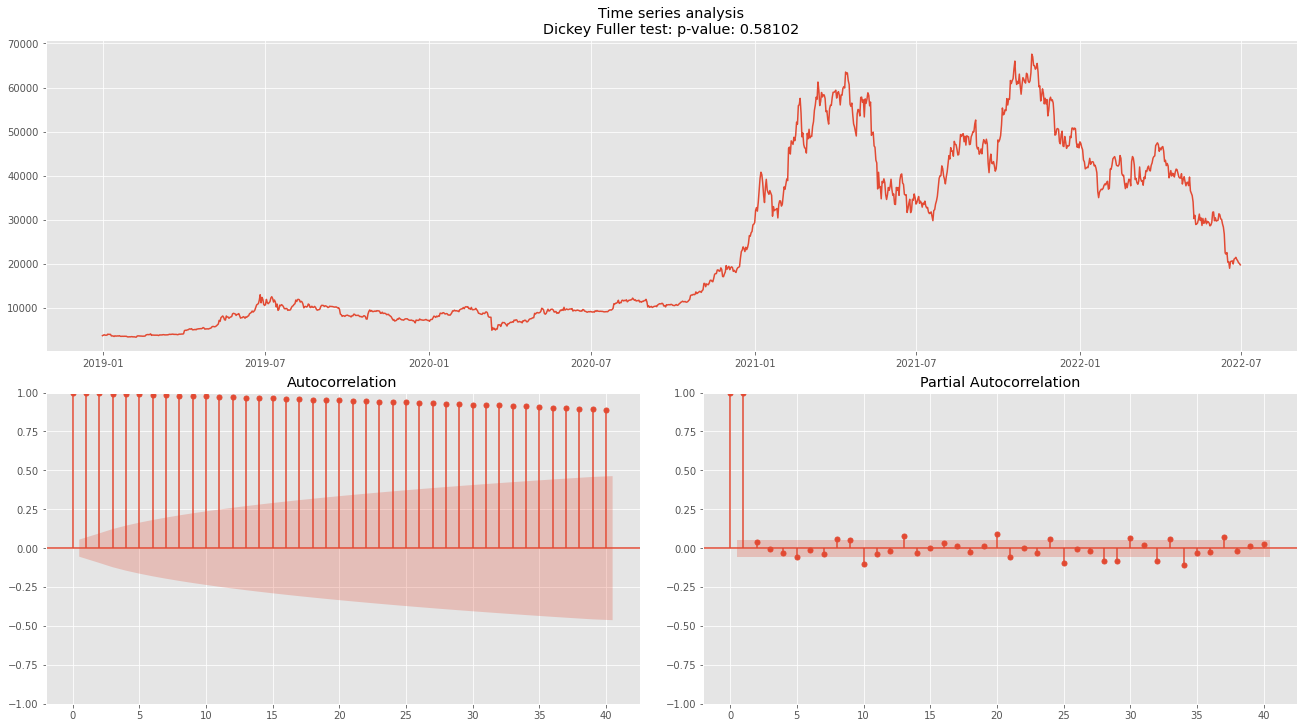

In [23]:
plot_tsa(btc_data['Close'], lags = 40)

E:\ProgramData\Miniconda3\envs\py3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


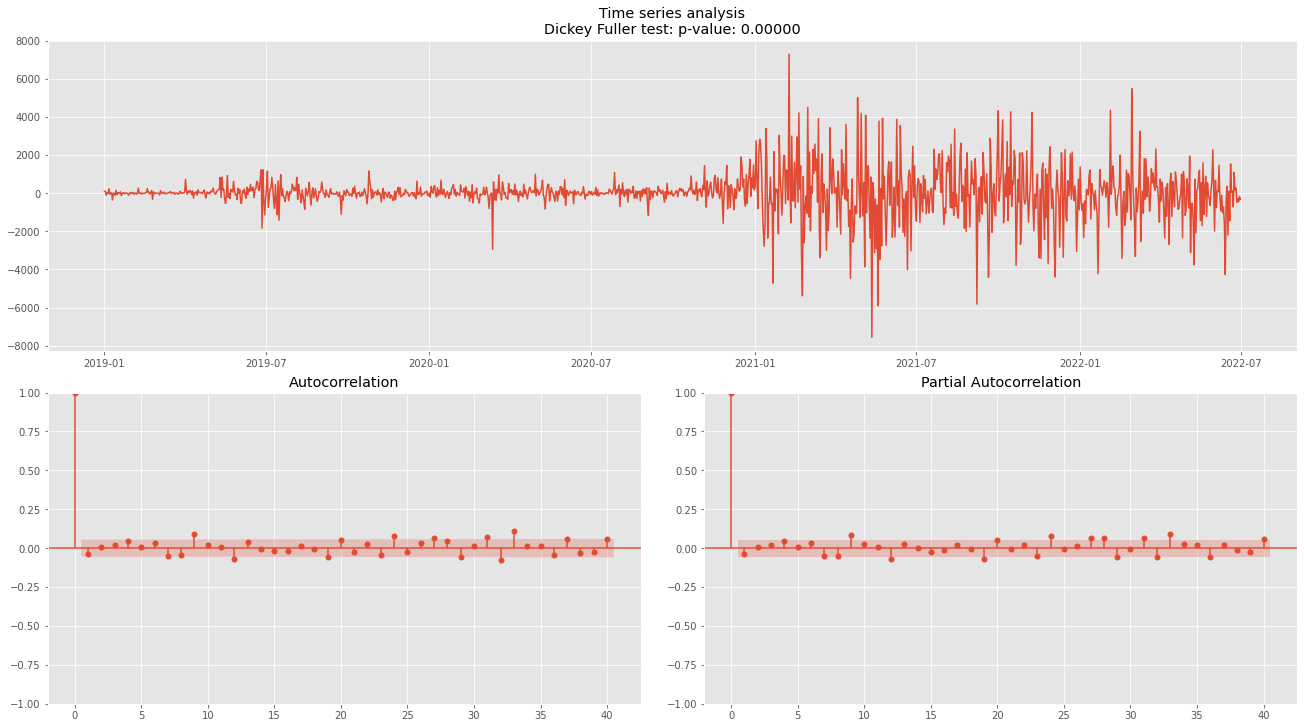

In [24]:
plot_tsa(btc_data['Close: 1st_diff'].dropna(), lags = 40)

#### Series looks stationary. The Partial autocorrelation plot shows no seasonality and the AR(p) value from the plot could be taken as 1 since the plot at lag 1 touches the confidence interval line although minimally.
#### Same goes for the ACF plot. We take the MA(q) value as 1
#### The integration(I)/difference value is 1. Lets model ARIMA

In [25]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
from itertools import product
from tqdm import tqdm_notebook
warnings.filterwarnings('ignore')

In [26]:
train_data = btc_data[:datetime.datetime(2022, 5, 31)]
test_data = btc_data[datetime.datetime(2022, 6, 1):]
train_data.head()

,Adj Close,Close,High,Low,Open,Volume,Close: 1st_diff
Date,,,,,,,
2018-12-31,3742.700439,3742.700439,3868.742920,3725.867432,3866.839111,4661840806,NaN
2019-01-01,3843.520020,3843.520020,3850.913818,3707.231201,3746.713379,4324200990,100.819580
2019-01-02,3943.409424,3943.409424,3947.981201,3817.409424,3849.216309,5244856836,99.889404
2019-01-03,3836.741211,3836.741211,3935.685059,3826.222900,3931.048584,4530215219,-106.668213
2019-01-04,3857.717529,3857.717529,3865.934570,3783.853760,3832.040039,4847965467,20.976318


In [27]:
def evaluate_arima(train, test, arima_order):
    
    train = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        try:
            model = ARIMA(train, order=arima_order).fit()
        except:
            continue
        yhat = model.forecast()[0]
        predictions.append(yhat)
        train.append(test[t])
    # calculate the rmse
    rmse = np.sqrt(mean_squared_error(test, predictions))
    return rmse

In [28]:
def evaluate_arima_models(train, test, params):
    
    results = []
    best_rmse, best_order = float("inf"), None
    
    for param in tqdm_notebook(params):
#         order = (param[0], param[1], param[2])
        rmse = evaluate_arima(train, test, param)
        
        if rmse < best_rmse:
            best_order = param
            best_rmse = rmse
        print('ARIMA%s RMSE=%.3f' % (param,rmse))
            
        results.append([param, rmse])
    
    print("Best ARIMA: %s with rmse of %.3f" % (best_order, best_rmse))
    
    return results

In [29]:
ps = range(0, 3)
qs = range(0, 3)
ds = range(0, 3)

params = list(product(ps, ds, qs))

results = evaluate_arima_models(train_data['Close'], test_data['Close'], params)

  0%|          | 0/27 [00:00<?, ?it/s]

ARIMA(0, 0, 0) RMSE=4497.975
ARIMA(0, 0, 1) RMSE=2663.254
ARIMA(0, 0, 2) RMSE=3419.326
ARIMA(0, 1, 0) RMSE=1190.329
ARIMA(0, 1, 1) RMSE=1196.001
ARIMA(0, 1, 2) RMSE=1195.326
ARIMA(0, 2, 0) RMSE=1595.345
ARIMA(0, 2, 1) RMSE=1197.294
ARIMA(0, 2, 2) RMSE=1203.253
ARIMA(1, 0, 0) RMSE=1187.998
ARIMA(1, 0, 1) RMSE=1193.241
ARIMA(1, 0, 2) RMSE=1192.396
ARIMA(1, 1, 0) RMSE=1195.860
ARIMA(1, 1, 1) RMSE=1195.822
ARIMA(1, 1, 2) RMSE=1188.443
ARIMA(1, 2, 0) RMSE=1389.716
ARIMA(1, 2, 1) RMSE=1203.008
ARIMA(1, 2, 2) RMSE=1189.649
ARIMA(2, 0, 0) RMSE=1193.166
ARIMA(2, 0, 1) RMSE=1192.749
ARIMA(2, 0, 2) RMSE=1193.698
ARIMA(2, 1, 0) RMSE=1195.525
ARIMA(2, 1, 1) RMSE=1200.056
ARIMA(2, 1, 2) RMSE=1169.824
ARIMA(2, 2, 0) RMSE=1293.939
ARIMA(2, 2, 1) RMSE=1202.726
ARIMA(2, 2, 2) RMSE=1200.200
Best ARIMA: (2, 1, 2) with rmse of 1169.824


In [30]:
results

[[(0, 0, 0), 4497.9745214095465],
 [(0, 0, 1), 2663.253959207738],
 [(0, 0, 2), 3419.3256839393966],
 [(0, 1, 0), 1190.3287599597165],
 [(0, 1, 1), 1196.0013922039618],
 [(0, 1, 2), 1195.3259100788075],
 [(0, 2, 0), 1595.345157884515],
 [(0, 2, 1), 1197.2943120677733],
 [(0, 2, 2), 1203.2531705969811],
 [(1, 0, 0), 1187.997927149328],
 [(1, 0, 1), 1193.2407975931055],
 [(1, 0, 2), 1192.3957364765454],
 [(1, 1, 0), 1195.859919152864],
 [(1, 1, 1), 1195.8220849466882],
 [(1, 1, 2), 1188.4426197428932],
 [(1, 2, 0), 1389.7161625087833],
 [(1, 2, 1), 1203.007964122069],
 [(1, 2, 2), 1189.6494392741445],
 [(2, 0, 0), 1193.1663441776702],
 [(2, 0, 1), 1192.7489295139023],
 [(2, 0, 2), 1193.6983597599422],
 [(2, 1, 0), 1195.5246279345954],
 [(2, 1, 1), 1200.0556906110555],
 [(2, 1, 2), 1169.8240151429966],
 [(2, 2, 0), 1293.939160897583],
 [(2, 2, 1), 1202.7263498351322],
 [(2, 2, 2), 1200.2001561620293]]

#### Lets implement the one-step ahead prediction and check the plots

In [31]:
preds = []
data = [x for x in train_data.Close]

for t in tqdm_notebook(range(len(test_data.Close))):
    best_model = ARIMA(data, order=(2, 1, 2)).fit()
    preds.append(best_model.forecast())
    data.append(test_data.Close[t])
test_data['ARIMA_predictions'] = preds

  0%|          | 0/30 [00:00<?, ?it/s]

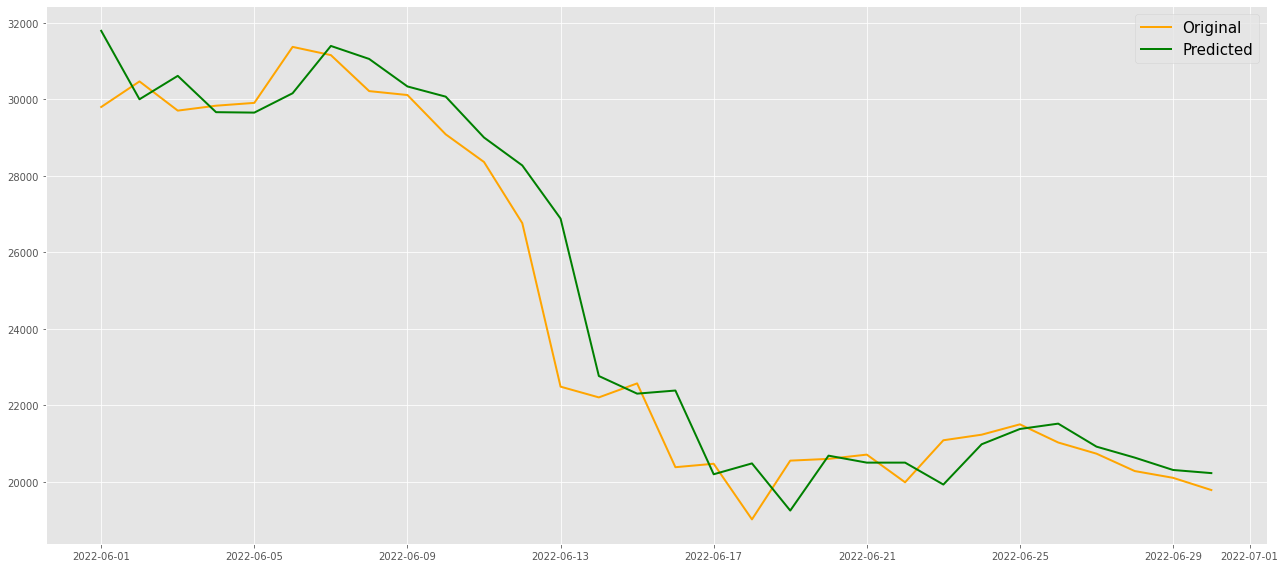

In [32]:
plt.figure(figsize=(18, 8))
plt.plot(test_data.Close, c='orange', linewidth=2, label="Original")
plt.plot(test_data.ARIMA_predictions, c='green', linewidth=2, label="Predicted")
plt.legend(loc='best', fontsize=15)
plt.tight_layout()
plt.show()

In [33]:
# Lets find out our mean absolute percentage error
print("Mean ABS percentage error:", mean_absolute_percentage_error(test_data.Close, test_data.ARIMA_predictions)*100, "%")
print("Root mean squared error:", np.sqrt(mean_squared_error(test_data.Close, test_data.ARIMA_predictions)))

Mean ABS percentage error: 3.335291729340041 %
Root mean squared error: 1169.8240151429966


#### We got a very low percentage error for one step ahead predictions for one month.  Lets check SARIMA model

In [34]:
def model_sarima(X, y, sarima_order):
    history = [x for x in X]
    predictions = list()
    for t in range(len(y)):
        try:
            model = SARIMAX(history, order=(sarima_order[0], sarima_order[1], sarima_order[2]),
                                   seasonal_order=(sarima_order[3], sarima_order[4], sarima_order[5], sarima_order[6]))
            model_fit = model.fit()
        except:
            continue
        fc = model_fit.forecast()[0]
        predictions.append(fc)
        history.append(y[t])
    return np.sqrt(mean_squared_error(y, predictions))

def evaluate_sarima_models(train, test, param_list):
    best_score, best_cfg = float("inf"), None
    train = train.astype("float")
    for param in tqdm_notebook(param_list):
        rmse = model_sarima(train, test, param)
        if rmse < best_score:
            best_score, best_cfg = rmse, param
        print('SARIMA%s RMSE=%.3f' % (param, rmse))
    print('Best SARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [35]:
# ps = [1]
# qs = [2]
# d = [1]
# Ps = [1]
# D = [1]
# Qs = [2]
# s = [7, 30]

# parameter_list = list(product(ps, d, qs, Ps, D, Qs, s))

# evaluate_sarima_models(train_data.Close, test_data.Close, parameter_list)

In [36]:
preds_sarimax = []
data = [x for x in train_data.Close]

for t in tqdm_notebook(range(len(test_data.Close))):
    
    best_model = SARIMAX(data, order=(2, 1, 2), seasonal_order=(1, 1, 1, 30), initialization='approximate_diffuse').fit()
    yhat = best_model.forecast()
    preds_sarimax.append(yhat)
    data.append(test_data.Close[t])
test_data['SARIMAX_predictions'] = preds_sarimax

print("RMSE: {}".format(np.sqrt(mean_squared_error(test_data.Close, preds_sarimax))))
print("MAPE: {}".format(mean_absolute_percentage_error(test_data.Close, preds_sarimax)))

  0%|          | 0/30 [00:00<?, ?it/s]

RMSE: 1164.086377622792
MAPE: 0.034785800474037676


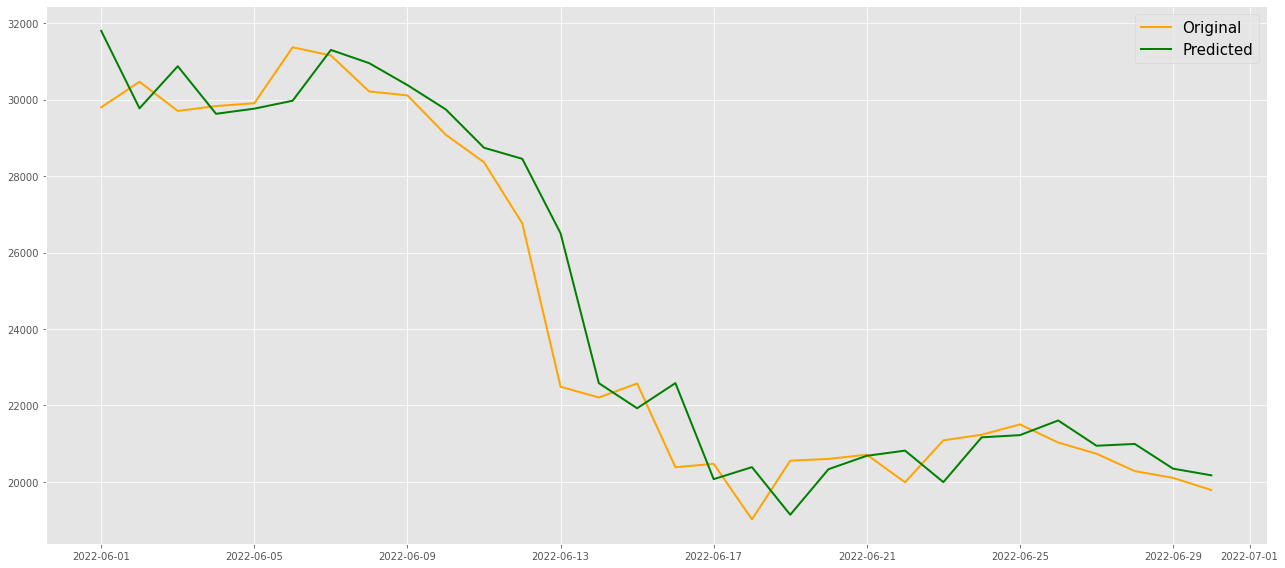

In [37]:
plt.figure(figsize=(18, 8))
plt.plot(test_data.Close, c='orange', linewidth=2, label="Original")
plt.plot(test_data.SARIMAX_predictions, c='green', linewidth=2, label="Predicted")
plt.legend(loc='best', fontsize=15)
plt.tight_layout()
plt.show()

In [38]:
resids = test_data.Close - test_data.SARIMAX_predictions
resids = [x[0] for x in resids]
test_data['residuals_sarima_best'] = resids

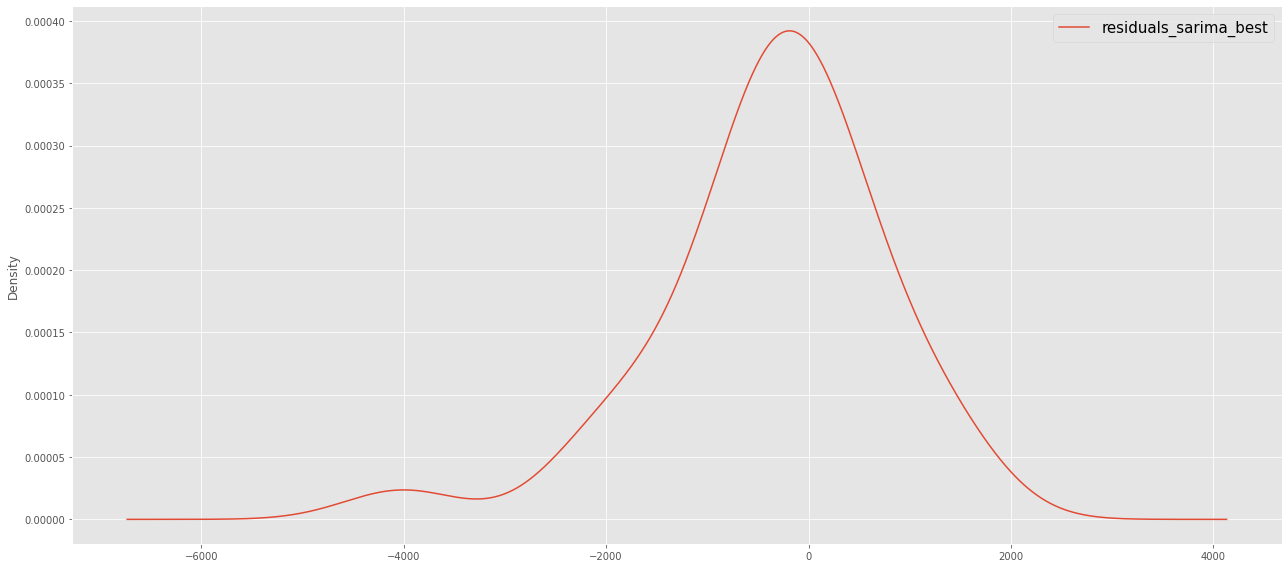

In [39]:
# plotting the residuals
plt.figure(figsize=(18, 8))
# plt.plot(test_data.Close - test_data.SARIMAX_predictions, c='orange', linewidth=2, label="Original")
test_data.residuals_sarima_best.plot(kind='kde')
plt.legend(loc='best', fontsize=15)
plt.tight_layout()
plt.show()

#### The residuals have a normal distribution, which is good

  0%|          | 0/30 [00:00<?, ?it/s]

RMSE: 1464.5133800304711
MAPE: 0.04578541486532052


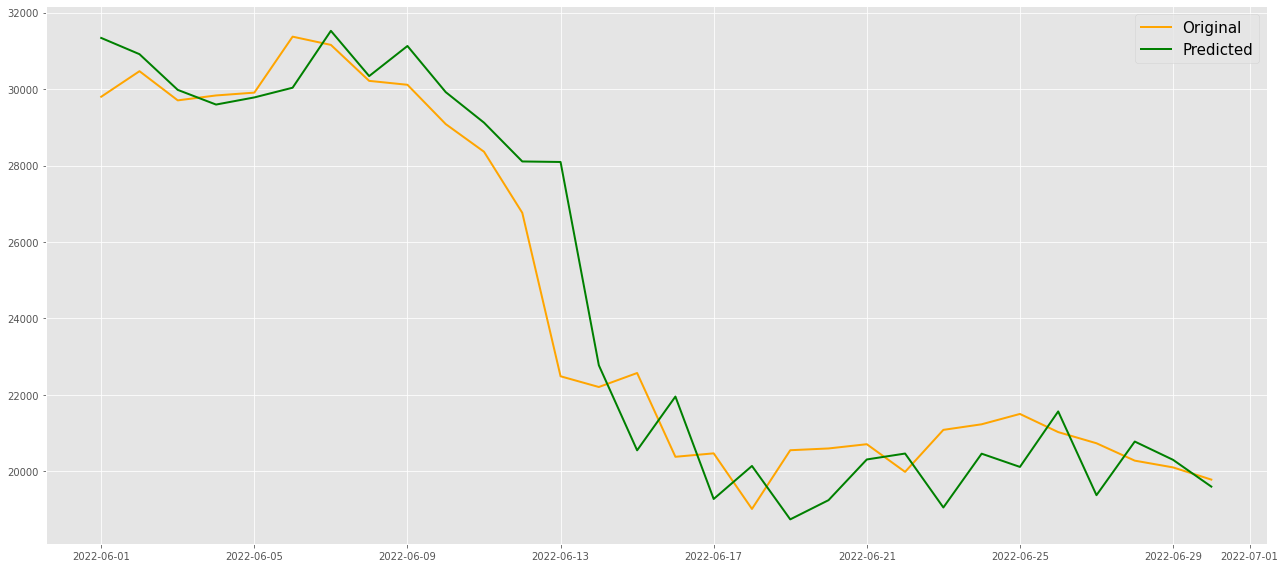

In [40]:
preds_sarimax = []
data = [x for x in train_data.Close]

for t in tqdm_notebook(range(len(test_data.Close))):
    best_model = SARIMAX(data, order=(2, 1, 2), seasonal_order=(1, 1, 0, 7)).fit()
    preds_sarimax.append(best_model.forecast())
    data.append(test_data.Close[t])
test_data['SARIMAX_predictions'] = preds_sarimax

print("RMSE: {}".format(np.sqrt(mean_squared_error(test_data.Close, preds_sarimax))))
print("MAPE: {}".format(mean_absolute_percentage_error(test_data.Close, preds_sarimax)))

plt.figure(figsize=(18, 8))
plt.plot(test_data.Close, c='orange', linewidth=2, label="Original")
plt.plot(test_data.SARIMAX_predictions, c='green', linewidth=2, label="Predicted")
plt.legend(loc='best', fontsize=15)
plt.tight_layout()
plt.show()

#### Both ARIMA and SARIMAX with the best order and seasonality gave the same RMSE and MAPE values, which means the data modelled with seasonality is not giving the any better estimates than normal ARIMA itself, which is quite obvious because the data is value of a currency in the market and it depends on many factors such as human sentiments, political decisions, crisis situations etc.

In [41]:
from pmdarima.arima import auto_arima

RMSE of Auto ARIMA Model : 1190.3287599597165


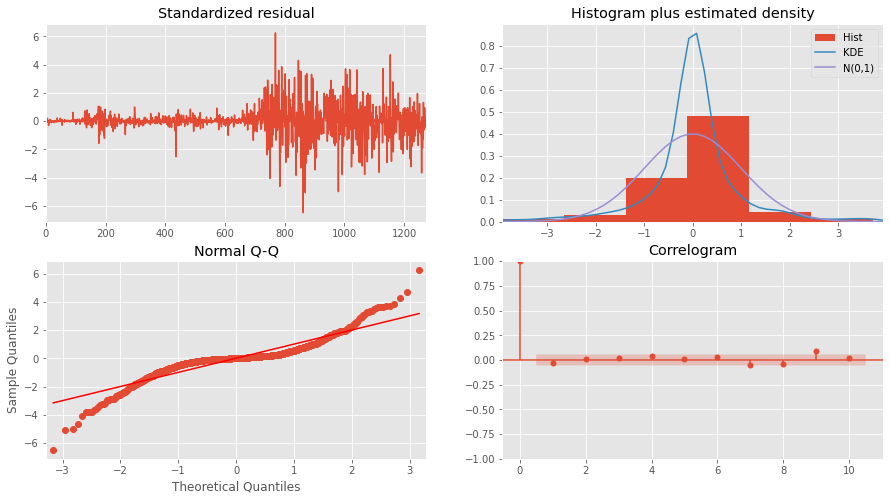

In [42]:
history = [x for x in train_data.Close]
predictions = list()
conf_list = list()

for t in range(len(test_data)):
    model_autoARIMA = auto_arima(history, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   
                      start_P=0, 
                      D=0, 
                      trace=False,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
    fc, confint = model_autoARIMA.predict(n_periods=1, return_conf_int=True)
    predictions.append(fc)
    history.append(test_data.Close[t])
    conf_list.append(confint)

print('RMSE of Auto ARIMA Model :', np.sqrt(mean_squared_error(test_data.Close, predictions)))
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

**Top left**: The residual errors appear to have a uniform variance and fluctuate around a mean of zero.

**Top Right**: The density plot on the top right suggests a normal distribution with a mean of zero.

**Bottom left**: The red line is not perfectly aligned with all of the dots. Any significant deviation indicates a skewed distribution.

**Bottom Right**: The residual errors are not autocorrelated, as shown by the Correlogram, also known as the ACF plot. Any autocorrelation would imply that the residual errors have a pattern that isn’t explained by the model. As a result, more Xs (predictors) needs to be added to the model.

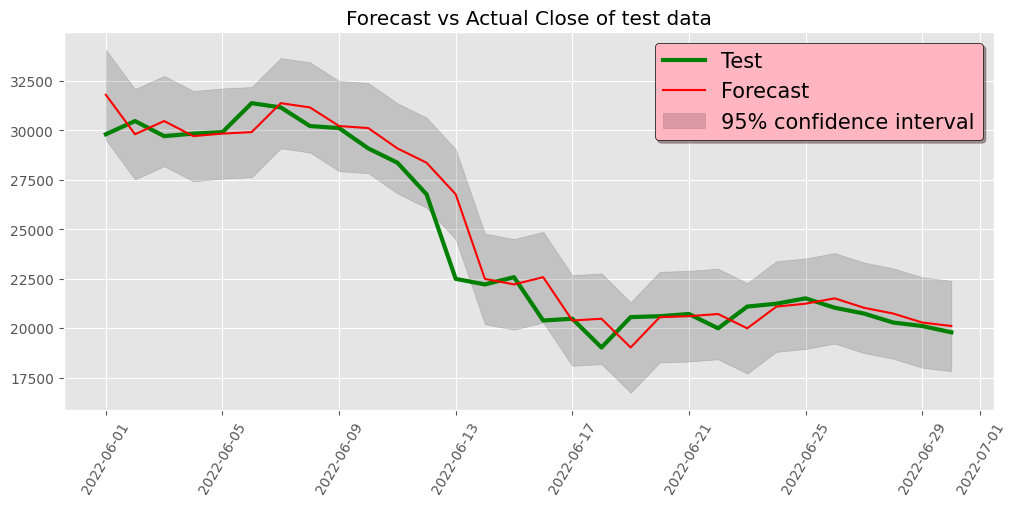

In [43]:
lower_series = []
upper_series = []
for i in conf_list:
    lower_series.append(i[0][0])
    upper_series.append(i[0][1])
fc_series = pd.Series(predictions, index=test_data.index)
lower_series = pd.Series(lower_series, index=test_data.index)
upper_series = pd.Series(upper_series, index=test_data.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
# plt.plot(train_data, label='Training', color = 'blue')
plt.plot(test_data.Close, label='Test', color = 'green', linewidth = 3)
plt.plot(fc_series, label='Forecast', color = 'red')
plt.fill_between(lower_series.index, lower_series, upper_series,
                 color='k', alpha=.15, label = '95% confidence interval')
plt.title('Forecast vs Actual Close of test data')
plt.xticks(rotation=60)
plt.legend(fontsize = 15, shadow=True,facecolor='lightpink',edgecolor = 'k')
plt.show()

#### This seems like a good model predicting the future close prices. Although our Sarimax model gave a little better predictions compared to this. Lets also check the both the model's long term forecasting

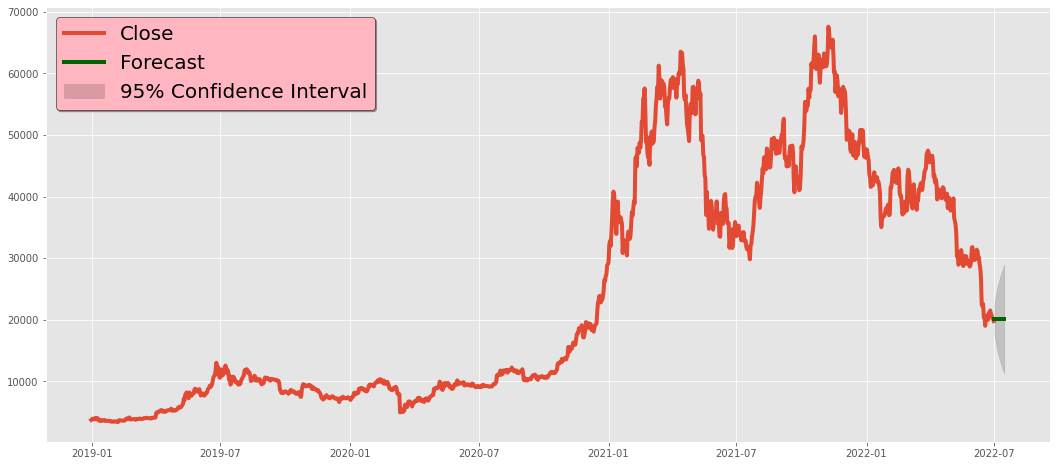

In [45]:
fc, confint = model_autoARIMA.predict(n_periods=15, return_conf_int=True)

# make series for plotting purpose
fc_series = pd.Series(fc, index=pd.date_range(start=datetime.datetime(2022, 7, 1), periods=15))
lower_series = pd.Series(confint[:, 0], index=pd.date_range(start=datetime.datetime(2022, 7, 1), periods=15))
upper_series = pd.Series(confint[:, 1], index=pd.date_range(start=datetime.datetime(2022, 7, 1), periods=15))

# Plot
plt.figure(figsize = (18,8))
plt.plot(btc_data['Close'], linewidth = 4, label = 'Close')
plt.plot(fc_series, color='darkgreen', linewidth = 4, label = 'Forecast')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15, label = '95% Confidence Interval')
plt.legend(fontsize = 20, shadow=True,facecolor='lightpink',edgecolor = 'k')
plt.show()

2022-07-01    19799.976116
2022-07-02    19825.081733
2022-07-03    20123.260479
2022-07-04    20041.417846
2022-07-05    19929.144869
2022-07-06    20159.594708
2022-07-07    20092.356647
2022-07-08    19951.434127
2022-07-09    20072.134976
2022-07-10    19861.214351
2022-07-11    19722.456073
2022-07-12    19793.678616
2022-07-13    19471.659532
2022-07-14    19509.555079
2022-07-15    19302.446175
2022-07-16    19280.116993
2022-07-17    18973.989470
Freq: D, Name: predicted_mean, dtype: float64

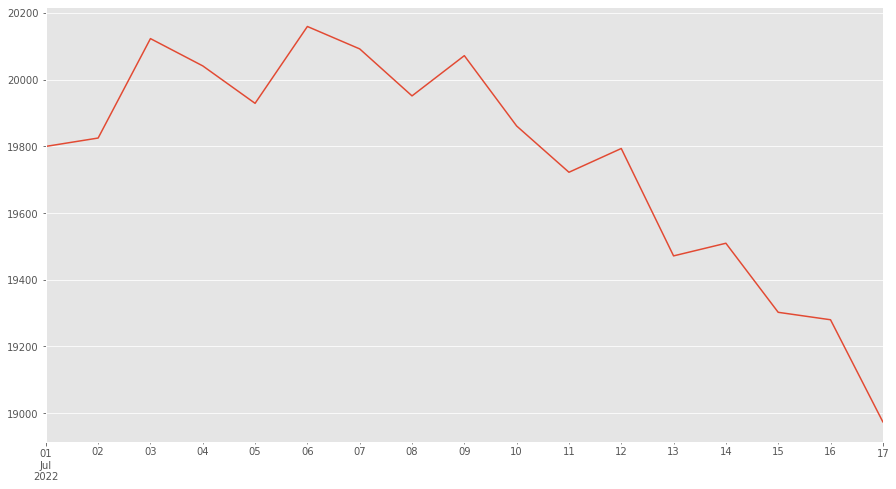

In [47]:
# Lets check on totally new and recent data
model_sarimax = SARIMAX(btc_data['Close'], order=(2, 1, 2), seasonal_order=(1, 1, 1, 30), initialize='approximate_diffuse').fit()
preds_sarimax = model_sarimax.predict(start=datetime.datetime(2022, 7, 1), end = datetime.datetime(2022, 7, 17), dynamic=True)

# preds_sarimax.plot(figsize=(15, 8))

preds_sarimax

In [58]:
btc_recent = pdr.get_data_yahoo(['BTC-USD'], start=datetime.datetime(2022, 7, 1))
btc_recent.drop(datetime.datetime(2022, 6, 30), inplace=True)
btc_recent.columns = adj_cols
btc_recent['Close']

Date
2022-07-01    19269.367188
2022-07-02    19242.255859
2022-07-03    19297.076172
2022-07-04    20231.261719
2022-07-05    20190.115234
2022-07-06    20548.246094
2022-07-07    21637.587891
2022-07-08    21731.117188
2022-07-09    21592.207031
2022-07-10    20860.449219
2022-07-11    19970.556641
2022-07-12    19323.914062
2022-07-13    20212.074219
2022-07-14    20569.919922
2022-07-15    20836.328125
2022-07-16    21190.316406
2022-07-17    20779.343750
2022-07-18    22219.472656
Name: Close, dtype: float64

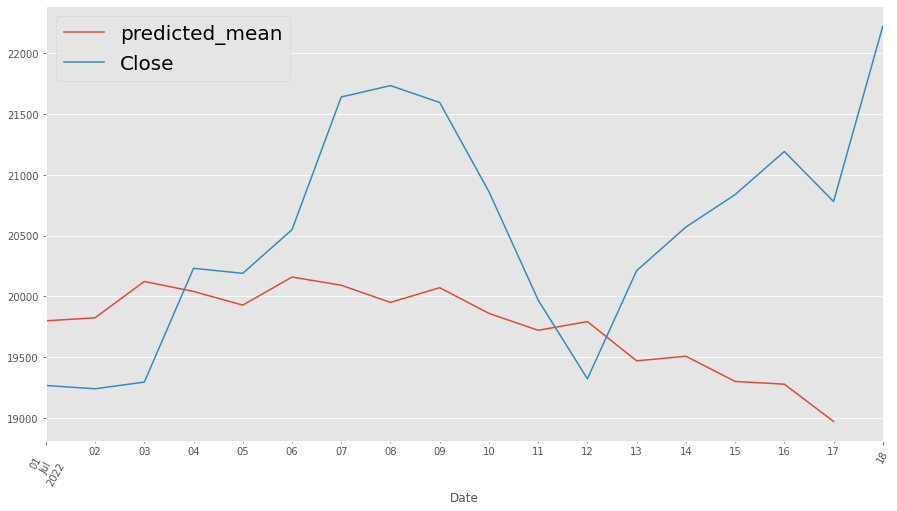

In [59]:
plt.figure(figsize=(15, 8))
preds_sarimax.plot()
btc_recent['Close'].plot()
plt.legend(loc='best', fontsize=20)
plt.xticks(rotation=60)
plt.show()

In [61]:
np.sqrt(mean_squared_error(btc_recent['Close'][:-1], preds_sarimax))

1128.2179878894153

In [62]:
preds_sarimax_one_step = []
data = [x for x in btc_data.Close]

for t in tqdm_notebook(range(len(btc_recent.Close))):
    
    best_model = SARIMAX(data, order=(2, 1, 2), seasonal_order=(1, 1, 1, 30), initialization='approximate_diffuse').fit()
    yhat = best_model.forecast()[0]
    preds_sarimax_one_step.append(yhat)
    data.append(btc_recent.Close[t])
    print("Predicted: %.2f, Actual: %.2f"%(yhat, btc_recent.Close[t]))
    
btc_recent['SARIMAX_predictions'] = preds_sarimax_one_step

print("RMSE: {}".format(np.sqrt(mean_squared_error(btc_recent.Close, preds_sarimax_one_step))))
print("MAPE: {}".format(mean_absolute_percentage_error(btc_recent.Close, preds_sarimax_one_step)))



  0%|          | 0/18 [00:00<?, ?it/s]

Predicted: 19747.40, Actual: 19269.37
Predicted: 19201.46, Actual: 19242.26
Predicted: 19447.68, Actual: 19297.08
Predicted: 19107.35, Actual: 20231.26
Predicted: 20105.38, Actual: 20190.12
Predicted: 20239.34, Actual: 20548.25
Predicted: 20485.34, Actual: 21637.59
Predicted: 21431.06, Actual: 21731.12
Predicted: 21806.37, Actual: 21592.21
Predicted: 21367.53, Actual: 20860.45
Predicted: 20594.52, Actual: 19970.56
Predicted: 20121.51, Actual: 19323.91
Predicted: 18969.65, Actual: 20212.07
Predicted: 20237.98, Actual: 20569.92
Predicted: 20299.93, Actual: 20836.33
Predicted: 20804.22, Actual: 21190.32
Predicted: 20896.87, Actual: 20779.34
Predicted: 20661.50, Actual: 22219.47
RMSE: 703.0305874959485
MAPE: 0.0267036713111063


AttributeError: 'list' object has no attribute 'plot'

<Figure size 1080x576 with 0 Axes>

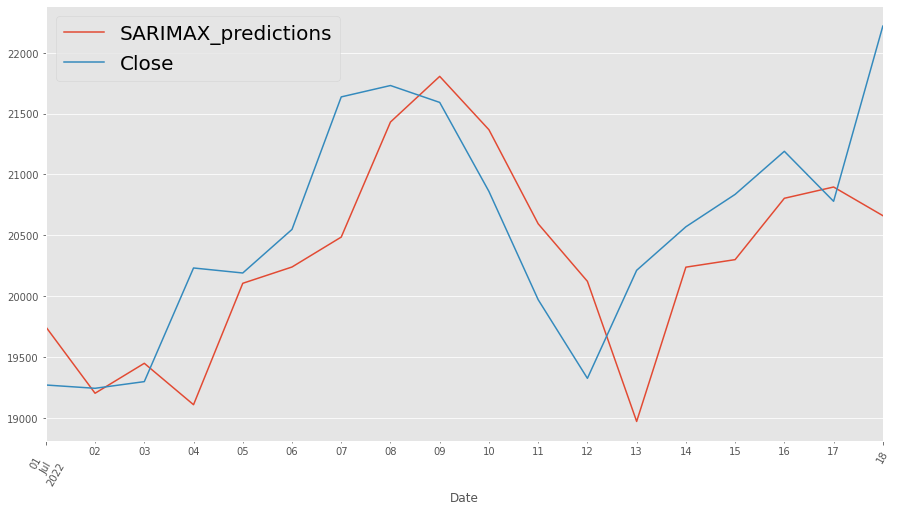

In [63]:
plt.figure(figsize=(15, 8))
btc_recent['SARIMAX_predictions'].plot()
btc_recent['Close'].plot()
plt.legend(loc='best', fontsize=20)
plt.xticks(rotation=60)
plt.show()

### Great the model gave quite good predictions for one-step ahead predictions with low rmse and mape value

In [65]:
model_sarimax = SARIMAX(data, order=(2, 1, 2), seasonal_order=(1, 1, 1, 30), initialize='approximate_diffuse').fit()
print("Predicted close on 19/07/2022 is", model_sarimax.forecast()[0])

Predicted close on 19/07/2022 is 22503.659231683007
